# Tool to extract usefull information from mlperf trace

In [6]:
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import json
import os
import seaborn as sns
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

figsize=(10, 5)
font=10

plt.figure(dpi=600)
plt.rc('xtick', labelsize=font) 
plt.rc('font', size=font)
sns.set(font_scale=1.4, style="whitegrid");

<Figure size 3600x2400 with 0 Axes>

In [7]:
def trace_to_df(fname):
    with open(fname, "r") as f:
        print(f)
        j = json.load(f)
    if type(j) == dict:
        j = j['traceEvents']
        
    result = []
    for item in j:
        name = item['name']
        if name not in ["Latency", "Sample", "QuerySamplesComplete", "IssueQuery"]:
            continue

        args = item.get('args')
        d = {"ts": item['ts'], "name": name, "dur": item.get("dur")}

        if name == "Latency":
            d["issue_delay"] = args["issue_delay"] /1e9
            d["issue_to_done"] = args["issue_to_done"] / 1e9
            result.append(d)
        elif name == "Sample":
            if args:
                d["issue_start_ns"] = args["issue_start_ns"]
                d["complete_ns"] = args["complete_ns"]
                d["issue_to_done"] = (args["complete_ns"] - args["issue_start_ns"]) / 1e9
                result.append(d)
        elif name == "QuerySamplesComplete":
            result.append(d)
        elif name == "IssueQuery":
            result.append(d)

    df = pd.DataFrame(result)
    df = df.sort_values(by=["ts"])
    return df

BINS = 10

In [8]:
# Fixing bin edges
HIST_BINS = np.linspace(0, 1000000, 100)

In [9]:
df = trace_to_df('/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-1-32-S-1-10/mlperf_log_trace.json')
df.describe()

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/output-exp22/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>


,ts,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
count,4.802000e+04,24010.000000,1.200500e+04,24010.000000,1.200500e+04,1.200500e+04
mean,4.133834e+07,3873.221525,1.697624e+01,11.016417,1.697624e+10,2.799266e+10
std,2.852758e+07,7212.683331,1.416478e+01,2.908724,1.416478e+10,1.591214e+10
min,1.960050e+05,3.011000,2.220000e-07,0.146377,2.220000e+02,1.463859e+08
25%,1.781401e+07,6.087000,2.188979e+00,12.145755,2.188979e+09,1.435780e+10
50%,3.751535e+07,45.319500,1.575882e+01,12.261240,1.575882e+10,2.800297e+10
75%,5.730396e+07,5077.102750,2.938598e+01,12.307844,2.938598e+10,4.166818e+10
max,1.156422e+08,85201.312000,4.319503e+01,13.140706,4.319503e+10,5.553629e+10


In [10]:
df["name"].unique()

array(['Sample', 'Latency', 'IssueQuery', 'QuerySamplesComplete'],
      dtype=object)

In [11]:
df

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
32,1.960050e+05,Sample,NaN,NaN,0.146377,8660.0,146385940.0
31,1.960050e+05,Latency,NaN,0.000009,0.146377,NaN,NaN
0,1.960152e+05,IssueQuery,117.724,NaN,NaN,NaN,NaN
42,2.132605e+05,Sample,NaN,NaN,0.158766,88964.0,158854679.0
41,2.132605e+05,Latency,NaN,0.000089,0.158766,NaN,NaN
...,...,...,...,...,...,...,...
48007,1.156336e+08,QuerySamplesComplete,5.511,NaN,NaN,NaN,NaN
48010,1.156343e+08,QuerySamplesComplete,5.612,NaN,NaN,NaN,NaN
48013,1.156369e+08,QuerySamplesComplete,6.510,NaN,NaN,NaN,NaN
48016,1.156420e+08,QuerySamplesComplete,10.615,NaN,NaN,NaN,NaN


In [12]:
df1 = df[df["name"].isin(["Sample"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
32,1.960050e+05,Sample,NaN,NaN,0.146377,8.660000e+03,1.463859e+08
42,2.132605e+05,Sample,NaN,NaN,0.158766,8.896400e+04,1.588547e+08
49,2.151299e+05,Sample,NaN,NaN,0.180541,6.118800e+04,1.806019e+08
56,2.222754e+05,Sample,NaN,NaN,0.205071,8.422600e+04,2.051549e+08
71,2.367617e+05,Sample,NaN,NaN,0.238382,1.121140e+05,2.384945e+08
...,...,...,...,...,...,...,...
48006,6.018522e+07,Sample,NaN,NaN,12.264782,4.318361e+10,5.544839e+10
48009,6.019079e+07,Sample,NaN,NaN,12.255490,4.318802e+10,5.544351e+10
48012,6.019285e+07,Sample,NaN,NaN,12.249021,4.319503e+10,5.544405e+10
48018,6.019572e+07,Sample,NaN,NaN,12.254237,4.319224e+10,5.544648e+10


In [13]:
df1 = df[df["name"].isin(["IssueQuery"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
0,1.960152e+05,IssueQuery,117.724,NaN,NaN,NaN,NaN
1,2.133538e+05,IssueQuery,73.206,NaN,NaN,NaN,NaN
2,2.151961e+05,IssueQuery,1279.242,NaN,NaN,NaN,NaN
3,2.223629e+05,IssueQuery,63.277,NaN,NaN,NaN,NaN
4,2.368800e+05,IssueQuery,114.567,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
44163,1.033688e+08,IssueQuery,9974.363,NaN,NaN,NaN,NaN
44170,1.033788e+08,IssueQuery,9063.663,NaN,NaN,NaN,NaN
44171,1.033879e+08,IssueQuery,79.233,NaN,NaN,NaN,NaN
44181,1.033880e+08,IssueQuery,3874.435,NaN,NaN,NaN,NaN


In [14]:
df1 = df[df["name"].isin(["Latency"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
31,1.960050e+05,Latency,NaN,0.000009,0.146377,NaN,NaN
41,2.132605e+05,Latency,NaN,0.000089,0.158766,NaN,NaN
48,2.151299e+05,Latency,NaN,0.000061,0.180541,NaN,NaN
55,2.222754e+05,Latency,NaN,0.000084,0.205071,NaN,NaN
70,2.367617e+05,Latency,NaN,0.000112,0.238382,NaN,NaN
...,...,...,...,...,...,...,...
48005,6.018522e+07,Latency,NaN,43.183610,12.264782,NaN,NaN
48008,6.019079e+07,Latency,NaN,43.188023,12.255490,NaN,NaN
48011,6.019285e+07,Latency,NaN,43.195032,12.249021,NaN,NaN
48017,6.019572e+07,Latency,NaN,43.192240,12.254237,NaN,NaN


In [15]:
df1 = df[df["name"].isin(["QuerySamplesComplete"])]
df1

,ts,name,dur,issue_delay,issue_to_done,issue_start_ns,complete_ns
33,3.423921e+05,QuerySamplesComplete,26.157,NaN,NaN,NaN,NaN
43,3.721166e+05,QuerySamplesComplete,19.930,NaN,NaN,NaN,NaN
50,3.957332e+05,QuerySamplesComplete,26.923,NaN,NaN,NaN,NaN
57,4.274315e+05,QuerySamplesComplete,21.168,NaN,NaN,NaN,NaN
72,4.752575e+05,QuerySamplesComplete,20.600,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
48007,1.156336e+08,QuerySamplesComplete,5.511,NaN,NaN,NaN,NaN
48010,1.156343e+08,QuerySamplesComplete,5.612,NaN,NaN,NaN,NaN
48013,1.156369e+08,QuerySamplesComplete,6.510,NaN,NaN,NaN,NaN
48016,1.156420e+08,QuerySamplesComplete,10.615,NaN,NaN,NaN,NaN


# server scenario

In [40]:
import pandas as pd
import glob
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

import numpy as np
import matplotlib.pyplot as plt
# include if using a Jupyter notebook
# %matplotlib inline

path = "/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/"
all_files = glob.glob(path + "*-s.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head()

,benchmark,k8senv,sbatch,numctn,cscenario,cbatch,reps,qps,mean,p50,p80,p90,p95,p99,p999
0,resnet,baseline,32,1,server,1,1,99.759074,32.645211,32.773385,51.721496,58.110764,61.187491,63.980205,67.115089
1,resnet,baseline,32,1,server,1,2,100.285574,32.032450,32.052371,50.999148,57.378747,60.628964,63.208141,64.601013
2,resnet,baseline,32,1,server,1,3,100.402620,32.031588,32.069496,50.898902,57.314305,60.442311,63.116354,65.565186
3,resnet,baseline,32,1,server,1,4,100.375967,32.049939,32.107914,50.959695,57.368215,60.510597,63.214565,64.658783
4,resnet,baseline,32,1,server,1,5,100.570499,31.916317,31.936650,50.784067,57.199632,60.264634,62.873378,64.422924


In [41]:
import pandas as pd
import glob
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

import numpy as np
import matplotlib.pyplot as plt
# include if using a Jupyter notebook
%matplotlib inline
dfg = df
dfg

,benchmark,k8senv,sbatch,numctn,cscenario,cbatch,reps,qps,mean,p50,p80,p90,p95,p99,p999
0,resnet,baseline,32,1,server,1,1,99.759074,32.645211,32.773385,51.721496,58.110764,61.187491,63.980205,67.115089
1,resnet,baseline,32,1,server,1,2,100.285574,32.032450,32.052371,50.999148,57.378747,60.628964,63.208141,64.601013
2,resnet,baseline,32,1,server,1,3,100.402620,32.031588,32.069496,50.898902,57.314305,60.442311,63.116354,65.565186
3,resnet,baseline,32,1,server,1,4,100.375967,32.049939,32.107914,50.959695,57.368215,60.510597,63.214565,64.658783
4,resnet,baseline,32,1,server,1,5,100.570499,31.916317,31.936650,50.784067,57.199632,60.264634,62.873378,64.422924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,resnet,cpumemory,32,32,server,1,6,177.640008,3.082131,2.989978,4.556120,5.574221,6.017098,7.261727,8.353964
126,resnet,cpumemory,32,32,server,1,7,177.998831,2.965526,2.855529,4.401012,5.389115,5.762728,7.183265,8.231588
127,resnet,cpumemory,32,32,server,1,8,178.146853,3.017887,2.897856,4.490597,5.450929,5.841749,7.249161,8.165713
128,resnet,cpumemory,32,32,server,1,9,178.380486,2.964471,2.840899,4.435546,5.414641,5.821636,7.068705,8.019002


In [42]:
# from numpy import percentile, mean, std

# l_gb = ['benchmark', 'cbatch','sbatch','numctn']

# df_results = []

# for model_name in df['benchmark'].unique():
#        df_bench = df[(df['benchmark']==model_name)] # everybenchmark
# #        print(df_bench)
#        for senario in df_bench.cscenario.unique():
#             df_senario = df_bench[df_bench.cscenario == senario]
#             df_senario = df_senario.groupby(l_gb, sort=False).apply(lambda x: pd.Series({
#                   'model_time_mean' : mean(x['qps']),
#                   'model_time_std' : std(x['qps']),
#               })).reset_index()
# #             s1 = pd.Series([model_name,senario,16,'C','CPU',np.nan,np.nan], \
# #                            index=['benchmark','senario','num_process','class','type','model_time_mean','model_time_std'])
# #             s2 = pd.Series([model_name,senario,16,'C','CPUMEM',np.nan,np.nan], \
# #                            index=['benchmark','senario','num_process','class','type','model_time_mean','model_time_std'])
#             df_results.append(df_senario)

In [43]:
# df_results = pd.concat(df_results, axis=0)
# df_results

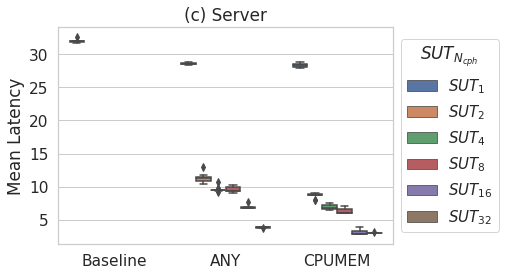

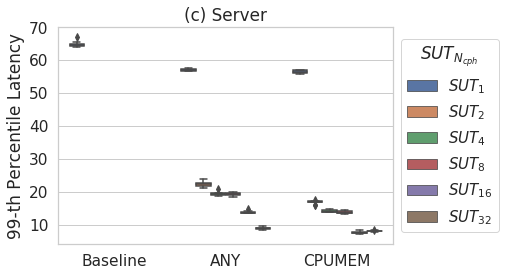

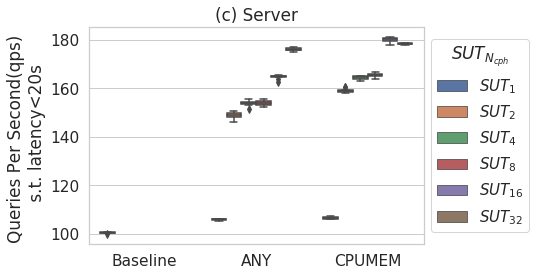

In [98]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from reportlab.pdfgen import canvas

from numpy import percentile, mean, std
import plotly.graph_objects as go

from plotly.offline import init_notebook_mode, iplot

import plotly.io as pio
pio.templates.default = "none"
# pio.templates.default = "simple_white"

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
# import plotly.express as px

# import seaborn library
import seaborn as sns
legend=['$SUT_{1}$','$SUT_{2}$','$SUT_{4}$','$SUT_{8}$','$SUT_{16}$','$SUT_{32}$']
ylabel=['Mean Latency','99-th Percentile Latency','Queries Per Second(qps) \n s.t. latency<20s']

label=0
for x in ['mean','p999','qps']:
    for cbatch in [1]:
        for model_name in ['resnet']:
            list_traces = []
            for env in ['baseline','none','cpumemory']:
    #             for numctn in [1,2,4,8,16,32]: 
                dfg_bench = dfg[(dfg['benchmark']== model_name)  & (dfg['cbatch']==cbatch) & \
    #                             (dfg['numctn']==numctn) &\
                            ((dfg['k8senv']==env))]
    #                          |\
    #                          (dfg['k8senv']=='cpumem')| (dfg['k8senv']=='cpumemory'))]
    #                 print(dfg_bench)
                list_traces.append(dfg_bench)
            dfall = pd.concat(list_traces, axis=0, ignore_index=True)
            ax = sns.boxplot(x = dfall['k8senv'],
                        y = dfall[x],
                        hue = dfall['numctn'])
            handles, _ = ax.get_legend_handles_labels()
            ax.legend(handles, legend, prop={'size': 15}, title = '$SUT_{N_{cph}}$',loc='center left', bbox_to_anchor=(1, 0.5))
#             plt.legend(legend,prop={'size': 16}, title = '$SUT_{N_{cph}}$',loc='center left', bbox_to_anchor=(1, 0.5) )
            ax.set_xticklabels(["Baseline","ANY","CPUMEM"])
            plt.xlabel("")
            plt.ylabel(ylabel[label])
            label=label+1
            plt.title("(c) Server")
            plt.savefig('s-metric.pdf',bbox_inches='tight')  
            plt.show()


In [111]:
df=dfg

In [115]:
from numpy import percentile, median, std

l_gb = ['benchmark', 'k8senv', 'sbatch','numctn','cscenario','cbatch']

df_results = []

for model_name in df['benchmark'].unique():
       df_bench = df[(df['benchmark']==model_name)] # everybenchmark
       for senario in df_bench.k8senv.unique():
            df_senario = df_bench[df_bench.k8senv == senario]
            df_base=df_senario[df_senario.numctn == 1]
            base=median(df_base['mean'])
            print(base)
            df_senario = df_senario.groupby(l_gb, sort=False).apply(lambda x: pd.Series({
                  'model_time_median' : median(x['mean']),
                  'increment' : (median(x['mean'])-base)/base,
              })).reset_index()
            df_results.append(df_senario)

31.97477669099988
28.516925655149723
28.30559579914985


In [116]:
df_results = pd.concat(df_results, axis=0)
df_results

,benchmark,k8senv,sbatch,numctn,cscenario,cbatch,model_time_median,increment
0,resnet,baseline,32,1,server,1,31.974777,0.000000
0,resnet,none,32,1,server,1,28.516926,0.000000
1,resnet,none,32,2,server,1,11.380095,-0.600935
2,resnet,none,32,4,server,1,9.476048,-0.667704
3,resnet,none,32,8,server,1,9.396227,-0.670504
4,resnet,none,32,16,server,1,6.819558,-0.760859
5,resnet,none,32,32,server,1,3.836527,-0.865465
0,resnet,cpumemory,32,1,server,1,28.305596,0.000000
1,resnet,cpumemory,32,2,server,1,8.741797,-0.691164
2,resnet,cpumemory,32,4,server,1,6.707864,-0.763020


In [117]:
from numpy import percentile, median, std

l_gb = ['benchmark', 'k8senv', 'sbatch','numctn','cscenario','cbatch','model_time_median','increment']

df_results1 = []

for ctn in df_results.numctn.unique():
    df_senario = df_results[df_results.numctn == ctn]
    df_base=df_senario[df_senario.k8senv == 'none']
    base=float(df_base['model_time_median'])
    print(base)
    df_senario = df_senario.groupby(l_gb, sort=False).apply(lambda x: pd.Series({
          'affinity' : (float(x['model_time_median'])-base)/base,
      })).reset_index()
    df_results1.append(df_senario)

df_results1 = pd.concat(df_results1, axis=0)
df_results1

28.516925655149723
11.380094592393593
9.476048373212695
9.396226645257773
6.819558334101992
3.8365266663055078


,benchmark,k8senv,sbatch,numctn,cscenario,cbatch,model_time_median,increment,affinity
0,resnet,baseline,32,1,server,1,31.974777,0.000000,0.121256
1,resnet,none,32,1,server,1,28.516926,0.000000,0.000000
2,resnet,cpumemory,32,1,server,1,28.305596,0.000000,-0.007411
0,resnet,none,32,2,server,1,11.380095,-0.600935,0.000000
1,resnet,cpumemory,32,2,server,1,8.741797,-0.691164,-0.231834
0,resnet,none,32,4,server,1,9.476048,-0.667704,0.000000
1,resnet,cpumemory,32,4,server,1,6.707864,-0.763020,-0.292124
0,resnet,none,32,8,server,1,9.396227,-0.670504,0.000000
1,resnet,cpumemory,32,8,server,1,6.075732,-0.785352,-0.353386
0,resnet,none,32,16,server,1,6.819558,-0.760859,0.000000


In [26]:
#y is the issue_start_ns
# df1 = df[df["name"].isin(["Sample"])]
# df1.reset_index(drop=True,inplace=True)
# ax = df1['issue_start_ns'].plot(figsize=figsize)
# ax.set(xlim=(0, 25000))
# ax.set_title('issue start time (usec)');

In [525]:
# df1['issue_start_ns'].sort_values

In [526]:
# df_time=df1['issue_start_ns'].shift()
# df_time
# df_time.dtype

In [527]:
#time poisson
# ax = df_time.plot(figsize=figsize)
# ax.set(xlim=(0, 10000))
# ax.set_title('issue start time (usec)');

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
75576.624


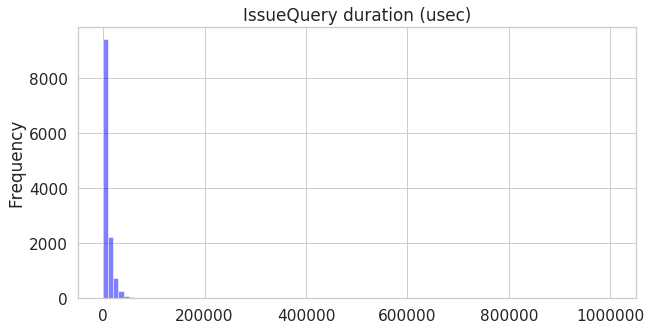

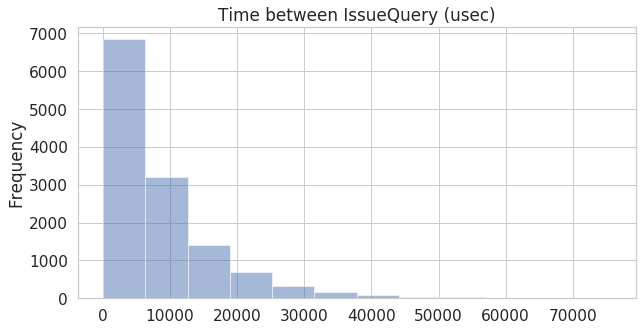

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
149466.947


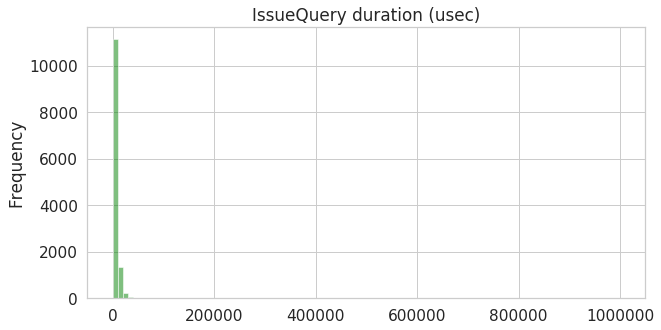

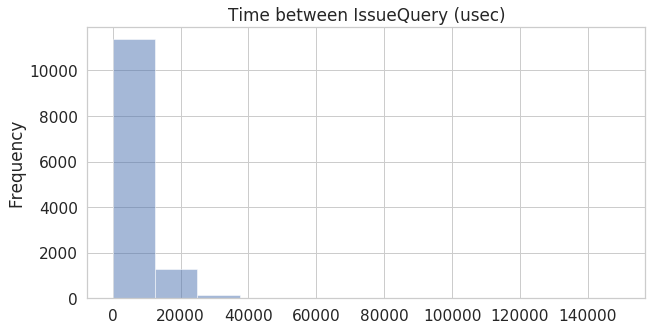

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
252578.441


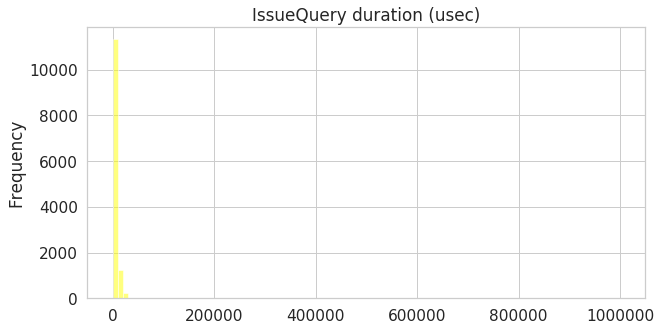

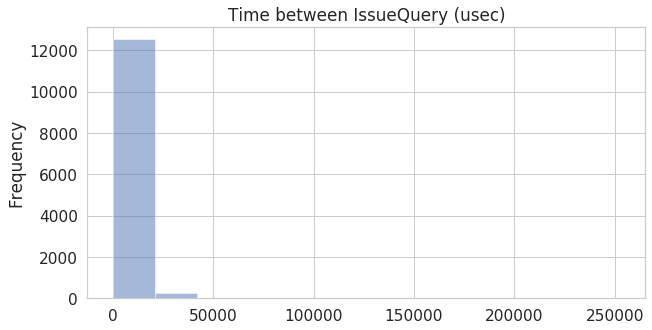

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
188214.58


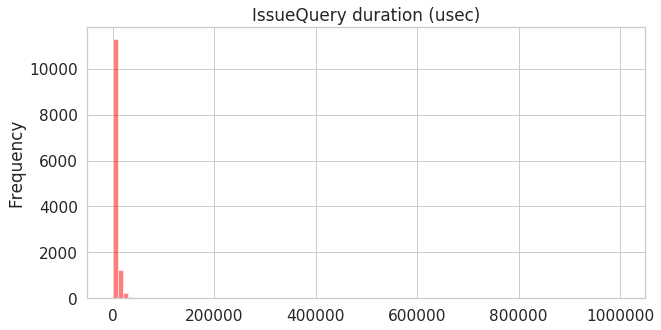

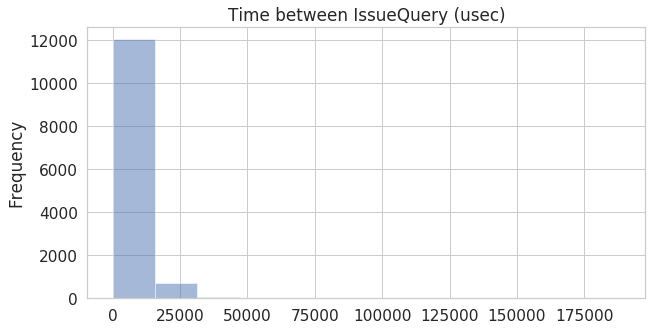

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-16-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
257331.871


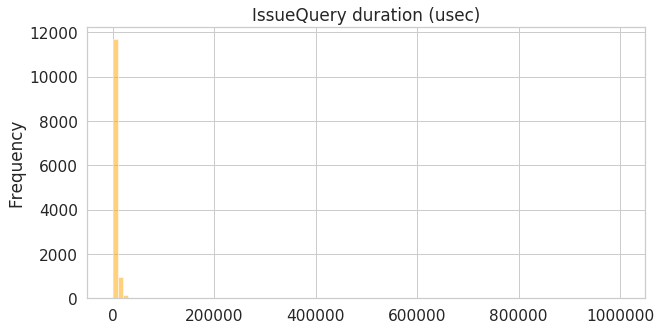

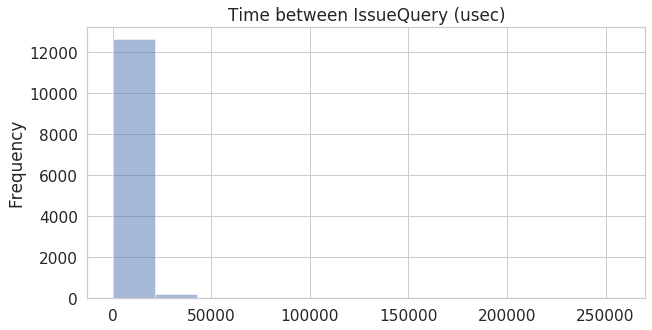

<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-32-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
311173.034


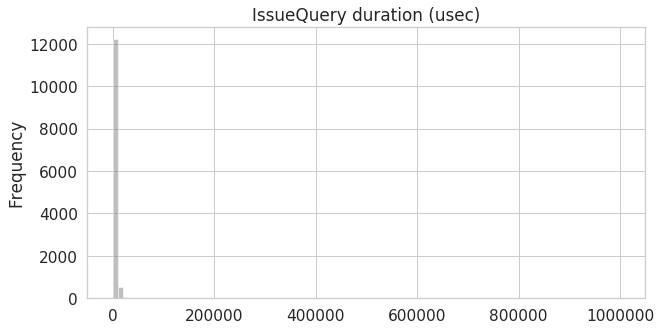

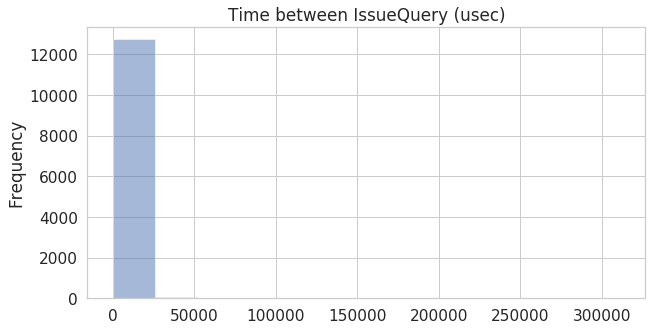

In [61]:
color=["blue","green","yellow","red","orange","grey"]
x=0
for add in ['none-resnet-1-32-S-1-10','none-resnet-2-32-S-1-10'
            ,'none-resnet-4-32-S-1-10',
           'none-resnet-8-32-S-1-10','none-resnet-16-32-S-1-10','none-resnet-32-32-S-1-10']:
    df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/"+add+"/mlperf_log_trace.json")
    df1 = df[df["name"].isin(["IssueQuery"])]
    print(max(df1['dur']))
    df1['delta'] = df1['ts'].diff()
#     plt.hist(df1['dur'], 50, density=True, facecolor='g', alpha=0.75)
    ax = df1['dur'].plot.hist(bins=HIST_BINS, alpha=0.5, figsize=figsize, fc=color[x])
    ax.set_title('IssueQuery duration (usec)');
    x = x+1
    plt.show()
    
    ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    ax.set_title('Time between IssueQuery (usec)');
    plt.show()

226919.99


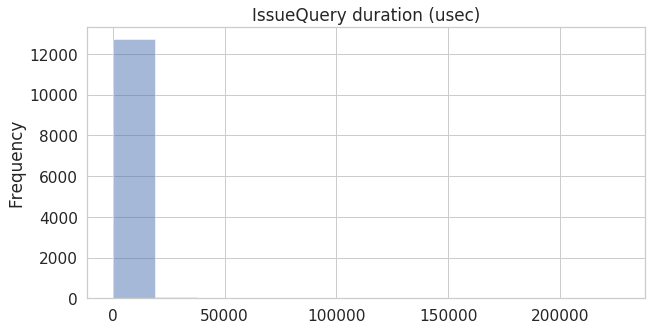

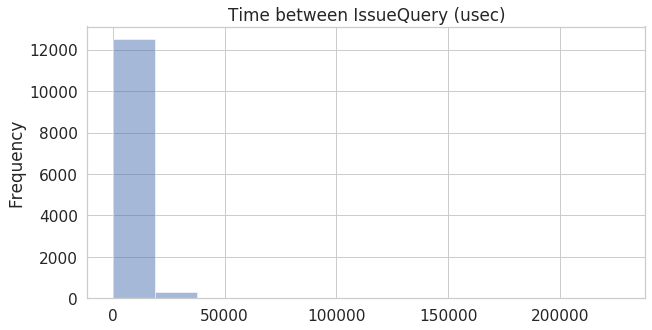

In [58]:
# df1 = df[df["name"].isin(["IssueQuery"])]
# df1['delta'] = df1['ts'].diff()
# ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# print(max(df1['dur']))
# ax.set_title('IssueQuery duration (usec)');
# # ax.set(xlim=(0, 80000))
# plt.show()
# ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Time between IssueQuery (usec)');

# # # df1['delta'].describe()

In [530]:
# for SingleStream
# if True:
#     df1 = df[df["name"].isin(["QuerySamplesComplete"])]
#     ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
#     ax.set_title('Inference time (usec)');
#     plt.show()
#     ax = df1['dur'].plot(figsize=figsize)
#     ax.set(ylim=(0, 600))
#     ax.set_title('Individual inference time (usec)');

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
15.150012229
11.9688511855
10.881602033866493
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
10.412214858
8.206540151
7.116049188136709
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
9.762265676
7.624882207500001
6.446132829530073
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UT

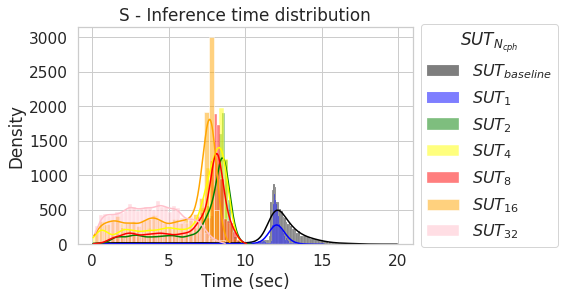

cpumemory
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
14.736126485
11.800599998
10.71051972715932
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
9.698752108
7.6122315865
6.365063706384127
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
10.152144875
6.456105394
5.483483599138908
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-8-32-S-1-10/mlperf_log_trace.json' mod

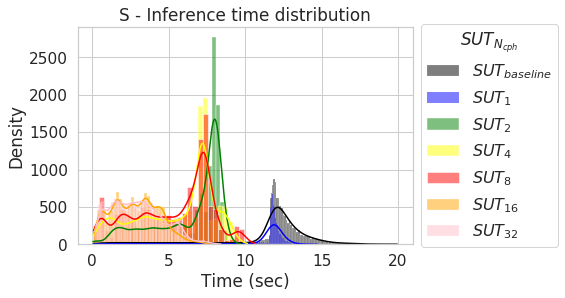

In [95]:
BINS=12
color=["black","blue","green","yellow","red","orange","pink"]
legend=['$SUT_{baseline}$','$SUT_{1}$','$SUT_{2}$','$SUT_{4}$','$SUT_{8}$','$SUT_{16}$','$SUT_{32}$']

for sc in ['none','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
          sc+'-resnet-2-32-S-1-10',
             sc+'-resnet-4-32-S-1-10',
               sc+'-resnet-8-32-S-1-10',
          sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-10/mlperf_log_trace.json")
    df1 = df[df["name"].isin(["Latency"])]
#     sns.distplot(df1['issue_to_done'], hist = False, kde = True,
#                      kde_kws = {'linewidth': 3},
#                      label = legend[x])
    sns.histplot(df1['issue_to_done'], kde = True,
#                      kde_kws = {'linewidth': 3},
                     label = legend[x],color=color[x])
    x=x+1
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Latency"])]
        print(max(df1['issue_to_done']))
        print(np.median(df1['issue_to_done']))
        print(np.mean(df1['issue_to_done']))
    #     ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    #     ax.set_title('Inference time (usec)');
    #     x = x+1
    #     plt.show()

        # Draw the density plot
#         sns.distplot(df1['issue_to_done'], hist = False, kde = True,
#                      kde_kws = {'linewidth': 3},
#                      label = legend[x])
        sns.histplot(df1['issue_to_done'], kde = True,
#                      kde_kws = {'linewidth': 3},
                     label = legend[x],color=color[x])
        x=x+1

    # Plot formatting
    plt.legend(prop={'size': 16}, title = '$SUT_{N_{cph}}$',loc='center left', bbox_to_anchor=(1, 0.5) )
#     handles, _ = ax.get_legend_handles_labels()
#     ax.legend(handles, legend, prop={'size': 15}, title = ,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('S - Inference time distribution')
    plt.xlabel('Time (sec)')
    plt.ylabel('Density')
    plt.savefig('s-itd'+sc+'.pdf',bbox_inches='tight')  
    plt.show()

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
45.186356288
16.8273507085
17.995179642579497
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
12.993258328
2.9290611909999997
4.183687234780793
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
9.836793175
1.11799313
2.7709924205287506
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
10.672057097
1.9341360145
3.246273317069216
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-16-32-S-1-10/mlperf_

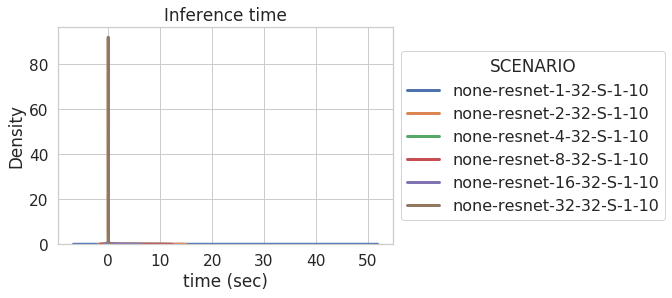

cpumem


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumem-resnet-1-32-S-1-10/mlperf_log_trace.json'

In [50]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]

for sc in ['none','cpumem','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
          sc+'-resnet-2-32-S-1-10',
             sc+'-resnet-4-32-S-1-10',
               sc+'-resnet-8-32-S-1-10',
          sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Latency"])]
        print(max(df1['issue_delay']))
        print(np.median(df1['issue_delay']))
        print(np.mean(df1['issue_delay']))
    #     ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
    #     ax.set_title('Inference time (usec)');
    #     x = x+1
    #     plt.show()

        # Draw the density plot
        sns.distplot(df1['issue_delay'], hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = SCEN[x])
        x=x+1

    # Plot formatting
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.title('Inference time')
    plt.xlabel('time (sec)')
    plt.ylabel('Density')
    plt.show()

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-1/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
12800
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-16-32-S-1-10/mlpe

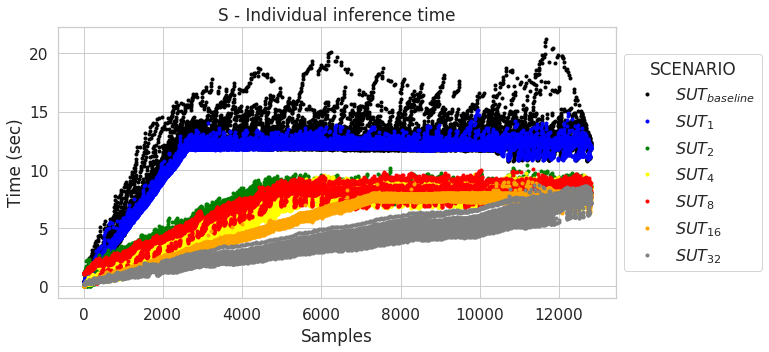

cpumemory
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-1/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
12800
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpum

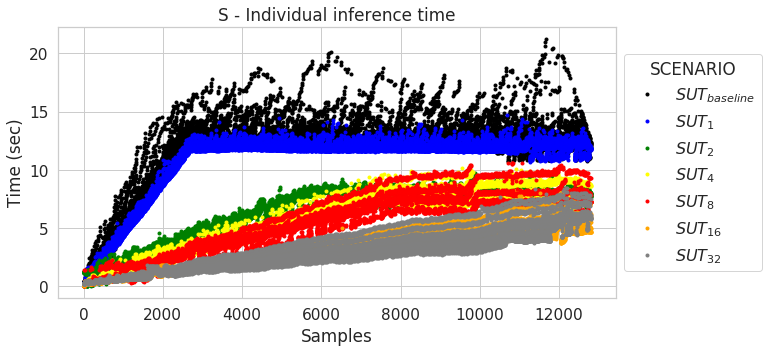

In [108]:
BINS=12
color=["black","blue","green","yellow","red","orange","grey"]
# legend=["baseline","ANY-1ctn","ANY-2ctn","ANY-4ctn","ANY-8ctn","ANY-16ctn","ANY-32ctn"]
legend=['$SUT_{baseline}$','$SUT_{1}$','$SUT_{2}$','$SUT_{4}$','$SUT_{8}$','$SUT_{16}$','$SUT_{32}$']
for sc in ['none','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
          sc+'-resnet-2-32-S-1-10',
             sc+'-resnet-4-32-S-1-10',
               sc+'-resnet-8-32-S-1-10',
          sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-1/mlperf_log_trace.json")
    df1 = df[df["name"].isin(["Sample"])]
    df1.reset_index(drop=True,inplace=True)
    print(len(df1))
    ax = df1['issue_to_done'].plot(figsize=figsize, color=color[x],label = legend[x],marker='.',linestyle='none')
    x=x+1
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Latency"])]
        df1.reset_index(drop=True,inplace=True)
        ax = df1['issue_to_done'].plot(figsize=figsize, color=color[x],label = legend[x],marker='.',linestyle='none')
#         ax = df1['issue_delay'].plot(figsize=figsize, color=color[x],label = legend[x])
        ax.set_title('Individual inference time (usec)');
    #     ax.set(ylim=(0, 100))
        x=x+1
    ax.set_title('S - Individual inference time');
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel('Samples')
    plt.ylabel('Time (sec)')
    plt.savefig('s-iit'+sc+'done.png',bbox_inches='tight') 
    plt.show()

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-1/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
12800
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/none-resnet-16-32-S-1-10/mlpe

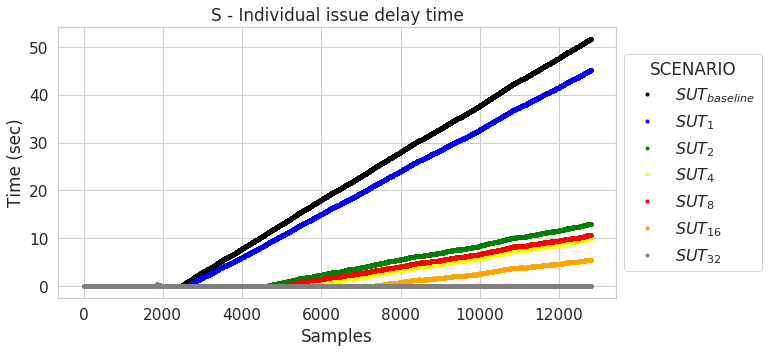

cpumemory
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-1/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
12800
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpumemory-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/cpum

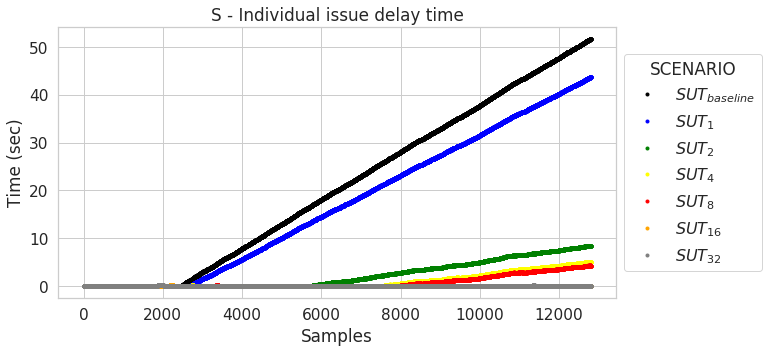

In [109]:
BINS=12
color=["black","blue","green","yellow","red","orange","grey"]
# legend=["baseline","ANY-1ctn","ANY-2ctn","ANY-4ctn","ANY-8ctn","ANY-16ctn","ANY-32ctn"]
legend=['$SUT_{baseline}$','$SUT_{1}$','$SUT_{2}$','$SUT_{4}$','$SUT_{8}$','$SUT_{16}$','$SUT_{32}$']
for sc in ['none','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
          sc+'-resnet-2-32-S-1-10',
             sc+'-resnet-4-32-S-1-10',
               sc+'-resnet-8-32-S-1-10',
          sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2-baseline/none-resnet-1-32-S-1-1/mlperf_log_trace.json")
    df1 = df[df["name"].isin(["Latency"])]
    df1.reset_index(drop=True,inplace=True)
    print(len(df1))
    ax = df1['issue_delay'].plot(figsize=figsize, color=color[x],label = legend[x],marker='.',linestyle='none')
    x=x+1
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp2/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["Latency"])]
        df1.reset_index(drop=True,inplace=True)
#         ax = df1['issue_to_done'].plot(figsize=figsize, color=color[x],label = legend[x])
        ax = df1['issue_delay'].plot(figsize=figsize, color=color[x],label = legend[x],marker='.',linestyle='none')
        ax.set_title('Individual inference time (usec)');
#         ax.set(ylim=(0, 2))
#         ax.set(xlim=(0, 1000))
        x=x+1
    ax.set_title('S - Individual issue delay time');
    plt.legend(prop={'size': 16}, title = 'SCENARIO',loc='center left', bbox_to_anchor=(1, 0.5) )
    plt.xlabel('Samples')
    plt.ylabel('Time (sec)')
    plt.savefig('s-iit'+sc+'delay.png',bbox_inches='tight') 
    plt.show()

In [469]:
# df1 = df[df["name"].isin(["Latency"])]
# ax = df1['issue_to_done'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Inference time (usec)');
# #ax.set(xlim=(0, 25000))
# plt.xticks(rotation=60)
# plt.show()

# ax = df1['issue_to_done'].plot(figsize=figsize)
# ax.set_title('Individual inference time (usec)');
# #ax.set(ylim=(0, 200))
# plt.show()


# # df1['issue_to_done'].describe()

In [468]:
# df1 = df[df["name"].isin(["QuerySamplesComplete"])]
# df1['delta'] = df1['ts'].diff()
# ax = df1['delta'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Time between QuerySamplesComplete (usec)');
# plt.show()

# ax = df1['dur'].plot.hist(bins=BINS, alpha=0.5, figsize=figsize)
# ax.set_title('Time QuerySamplesComplete (usec)');

none
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/none-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/none-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/none-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/none-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/none-resnet-16-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/none-resnet-32-32-S-1-10/mlperf_log_trace.

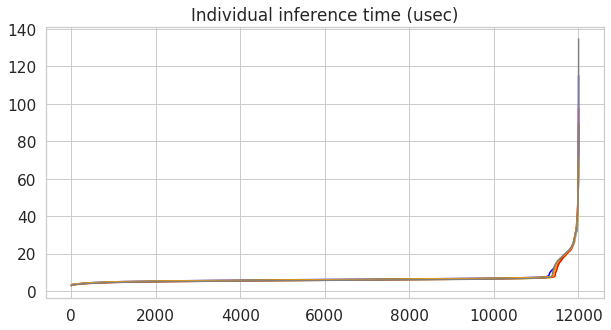

cpumem
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumem-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumem-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumem-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumem-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumem-resnet-16-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumem-resnet-32-32-S-1-10/mlp

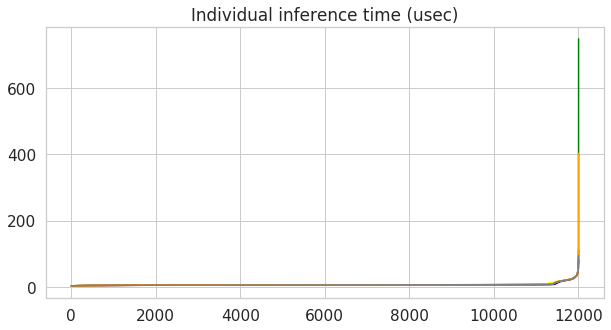

cpumemory
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumemory-resnet-1-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumemory-resnet-2-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumemory-resnet-4-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumemory-resnet-8-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumemory-resnet-16-32-S-1-10/mlperf_log_trace.json' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/cpumemory-re

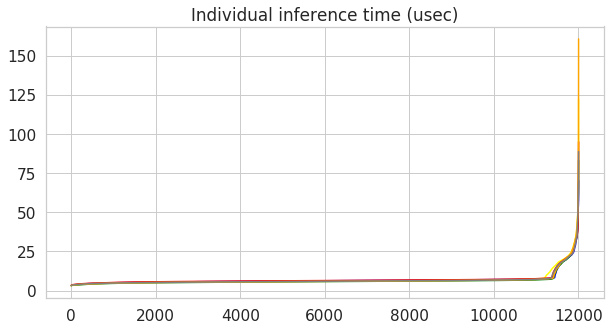

In [57]:
BINS=12
color=["blue","green","yellow","red","orange","grey"]
for sc in ['none','cpumem','cpumemory']:
    print(sc)
    SCEN=[sc+'-resnet-1-32-S-1-10',
          sc+'-resnet-2-32-S-1-10',
             sc+'-resnet-4-32-S-1-10',
               sc+'-resnet-8-32-S-1-10',
          sc+'-resnet-16-32-S-1-10',
          sc+'-resnet-32-32-S-1-10']
    x=0
    for add in SCEN:
        df = trace_to_df("/gpfs/bsc_home/xpliu/inference/vision/classification_and_detection/exp1/"+add+"/mlperf_log_trace.json")
        df1 = df[df["name"].isin(["QuerySamplesComplete"])]
        df1.sort_values("dur",inplace=True)
        df1.reset_index(drop=True,inplace=True)
        ax = df1['dur'].plot(figsize=figsize, color=color[x],label = SCEN[x])
        ax.set_title('Individual inference time (usec)');
#         ax.set(xlim=(11000, 12500))
        x=x+1
    plt.show()